
<font size = "5"> **Chapter 2: [Diffraction](Ch2-Diffraction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />


# Analyzing Ring Diffraction Pattern

part of 


<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Import important python packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all widget
%gui qt

# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from the book
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the file tool library of pyTEMlib
import pyTEMlib.file_tools as ft

print('pyTEM version: ',pyTEMlib.__version__)

__notebook__='CH2-Diffraction_Rings'
__notebook_version__='2020-03-06'

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2020.11.0


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## Load Ring-Diffraction Pattern
### First we select the diffraction pattern

Load the **GOLD-NP-DIFF.dm3** file as an example.

The dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

In [3]:
sidpy_dataset = ft.open_file(".\example_data\GOLD-NP-DIFF.dm3")



Cannot overwrite file. Using:  GOLD-NP-DIFF-4.hf5


AttributeError: module 'pyNSID' has no attribute 'hdf_io'

In [103]:
plt.close('all')
print(current_channel.keys())
tags = ft.h5_get_dictionary(current_channel)
data = np.array(tags['data'])
print(data.shape)
plt.figure()
#plt.plot(np.gradient(data[int(data.shape[0]/2),:]))
#plt.plot(np.gradient(data[:,int(data.shape[1]/2)]))
#plt.plot((data[int(data.shape[0]/2),:]))
#plt.plot((data[:,int(data.shape[1]/2)]))
print()
from scipy import signal
peaks, _ = signal.find_peaks(data[int(data.shape[0]/2),:],prominence=3000)
peaks2, _ = signal.find_peaks(data[:,int(data.shape[0]/2)],prominence=3000)
plt.plot(peaks, data[int(data.shape[0]/2),peaks], "o")
plt.plot(peaks2, data[peaks2,int(data.shape[0]/2)], "o")





<KeysViewHDF5 ['Position_Indices', 'Position_Values', 'Raw_Data', 'Spectroscopic_Indices', 'Spectroscopic_Values', 'data_type', 'filename', 'original_metadata', 'original_path', 'spatial_origin_x', 'spatial_origin_y', 'spatial_scale_x', 'spatial_scale_y', 'spatial_size_x', 'spatial_size_y', 'spatial_units', 'title']>
(2048, 2048)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


[ 750 1448] 1024
1024 [ 711 1402]
333


In [147]:
plt.close('all')
sorted2 =  np.argsort(abs(peaks2-1024))
sorted1 =  np.argsort(abs(peaks-1024))

points = [[peaks2[sorted2[2]],int(data.shape[0]/2)],[int(data.shape[0]/2),peaks[sorted1[3]]],[peaks2[sorted2[3]],int(data.shape[0]/2)],[int(data.shape[0]/2),peaks[sorted1[2]]] ]
#,print(points)
points = np.array(points)

#Find X Midpoints:
XMid1= (points[0,0]+points[1,0]) / 2.
XMid2= (points[0,0]+points[2,0]) / 2.

#Find Y Midpoints:
YMid1= (points[0,1]+points[1,1]) / 2.
YMid2= (points[0,1]+points[2,1]) / 2.

#Slope 1:
Slope1= (points[0,0]-points[1,0]) / (points[1,1]-points[0,1]+1e-12)

#Slope 2:
Slope2= (points[0,0]-points[2,0]) / (points[2,1]-points[0,1]+1e-12)
print(Slope1,Slope2)
#Perpendicular 1:
Perp1= YMid1 - (Slope1 * XMid1)

#Perpendicular 2:
Perp2= YMid2 - (Slope2 * XMid2)

XCenter = (Perp1 - Perp2) / Slope2 - Slope1
YCenter = Perp1 + (Slope1 * XCenter)

Circle_Radius = np.sqrt((XCenter - points[0,0])**2 + (YCenter - points[0,1])**2 )
print(XCenter,YCenter)

plt.figure()
plt.imshow(data)
plt.scatter(YCenter,XCenter)
plt.scatter(points[0:3,1],points[0:3,0], color='red')
center[0] = XCenter
center[1] = YCenter

selector = EllipseSelector(plt.gca(), None,interactive=True , drawtype='box')  # gca get current axis (plot)

selector.to_draw.set_visible(True)
radius = Circle_Radius 
center = np.array(center)

selector.extents = (center[1]-radius,center[1]+radius,center[0]-radius,center[0]+radius)


-0.7248677248677229 -698000000000000.0
1099.7248677248665 1058.802609109489


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Finding the center

### First try with cross correlation of rotated images


### Cross- and Auto- Correlation

Cross correlation and auto correlation are based on a  multiplication in Fourier space. In the case of a an auto-correlation it is the same data while in the cross correlation it is another data (here the transposed (rotated) diffraction pattern)

In [153]:
## Access the data of the loaded image
#data = current_channel['Raw_Data'][()]
diff_pattern = np.reshape(data, [current_channel['spatial_size_x'][()], current_channel['spatial_size_y'][()]])
diff_pattern = diff_pattern-diff_pattern.min()
correlation = 'auto'
dif_ft = np.fft.fft2(diff_pattern)
if correlation == 'auto':
    auto_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft))
    center = np.unravel_index(np.argmax(auto_correlation.real, axis=None), auto_correlation.real.shape)
    plt.figure()
    plt.title('Auto-Correlation')
    plt.imshow(auto_correlation.real);
else:   
    dif_ft2 = np.fft.fft2(diff_pattern.T)
    cross_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft2))
    center = np.unravel_index(np.argmax(cross_correlation.real, axis=None), cross_correlation.real.shape)
    plt.figure()
    plt.title('Cross-Correlation')
    plt.imshow(auto_correlation.real);
    
shift = np.array(center - np.array(dif_ft.shape)/2)
print(f'center = {center} which is a shift of {shift[0]} px in x and {shift[1]} px in y direction')
plt.scatter([center[1]],[center[0]]);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

center = (1182, 1090) which is a shift of 158.0 px in x and 66.0 px in y direction


### How well did we do?

### Select the center yourself

The beam stop confuses the cross correlation sometimes and then we need to  adjust the selection

In [155]:
from matplotlib.widgets import  EllipseSelector

print(np.array(center)-2048)
center = np.array(center)
center[0] = XCenter
center[1] = YCenter

plt.figure(figsize=(8, 6))
plt.imshow(np.log(1.+diff_pattern),origin = 'upper')
selector = EllipseSelector(plt.gca(), None,interactive=True , drawtype='box')  # gca get current axis (plot)

selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[1]-radius,center[1]+radius,center[0]-radius,center[0]+radius)


[-990 -949]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## First Result

We store the result in the out_tags dictionary.

See [Keeping Track of Analysis and Results](CH1-PyUSID.ipynb#Keeping_Track_of_Analysis_and_Results) in the [PyUSID](CH1-PyUSID.ipynb) notebook

In [156]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius = 559 pixels
new center = (1058.0, 1099.0) [pixels]


## Ploting Diffraction Pattern in Polar Coordinates

### The Transformation Routine

In [159]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff,center):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[0]
    y = np.linspace(1, ny, ny, endpoint = True)-center[1]
    z = diff

    # Define new polar grid
    nr = int(min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1)
    print(nr)
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

### Now we transform

If the center is correct a ring in carthesian coordinates is a line in polar coordinates

A simple sum over all angles gives us then the diffraction profile (intensity profile of diffraction pattern)

In [160]:
import time
starttime = time.time()
polar_projection = warp(diff_pattern,center)
print(time.time()-starttime)

948
0.7187521457672119


In [161]:
print(center[0])
center = np.array(center)
#center[1] = 1057
center[0]= 1103
center[1]=1055

polar_projection = warp(diff_pattern,center)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

out_tags['polar_projection'] = polar_projection

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)
profile_0 = polar_projection[:,0:20].sum(axis=1)
profile_360 = polar_projection[:,340:360].sum(axis=1)
profile_180 = polar_projection[:,190:210].sum(axis=1)

profile_90 = polar_projection[:,80:100].sum(axis=1)
profile_270 = polar_projection[:,260:280].sum(axis=1)


out_tags['radial_average'] = profile

scale = current_channel['spatial_scale_x'][()]

plt.figure()
plt.imshow(np.log2(1+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)
ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');
#plt.plot(profile_0/profile_0.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
#plt.plot(profile_360/profile_360.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
#plt.plot(profile_180/profile_180.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='b');
plt.plot(profile_90/profile_90.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
plt.plot(profile_270/profile_270.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='b');


plt.plot([0,360],[3.8,3.8])
plt.plot([0,360],[6.3,6.3])

1058.0
944


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

In [180]:
import scipy as sp
import scipy.signal as signal
peaks, g= signal.find_peaks(profile,  rel_height = .9, width = 7)#np.std(second_deriv)*9)

scale = current_channel['spatial_scale_x'][()]*4.28/3.75901247*1.005
# find_Bragg peaks in profile
peaks, g= signal.find_peaks(profile, rel_height = .7, width = 7)#np.std(second_deriv)*9)

print(peaks*scale)

out_tags['ring_radii_px'] = peaks


plt.figure()

plt.imshow(np.log2(1.+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)

ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');

for i in peaks:
    if i*scale > 3.5:
        plt.plot((0,360),(i*scale,i*scale), linestyle='--', c = 'steelblue')

[ 0.45905208  1.05199435  1.20501171  1.93184417  3.76805249  6.75189101
  7.66999517 10.97899558 12.85345824 17.19532583]


<ipython-input-180-ce70f12bc1ac>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Calculate Ring Pattern

see [Structure Factors](Structure_Factors.ipynb) for details


In [181]:
#Initialize the dictionary with all the input
tags = ks.structure_by_name('gold')
ks.h5_add_crystal_structure(h5_file, tags)


#Reciprocal Lattice 
# We use the linear algebra package of numpy to invert the unit_cell "matrix"
reciprocal_unit_cell = np.linalg.inv(tags['unit_cell']).T # transposed of inverted unit_cell

#INPUT
hkl_max = 7#  maximum allowed Miller index

acceleration_voltage = 200.0 *1000.0 #V
wave_length  = ks.get_waveLength(acceleration_voltage)



h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all to be evaluated single Miller Index
hkl  = np.array(list(itertools.product(h,h,h) )) # all to be evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)  

# Calculate Structure Factors

structure_factors = []

base = np.dot(tags['base'],tags['unit_cell'])  # transformation from relative to Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(tags['elements'][b],np.linalg.norm(g_hkl[j])) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

distances = np.linalg.norm(g_hkl, axis = 1)

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]

sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')

intensity = np.absolute(F[indices]**2*(np.roll(indices,-1)-indices))
print('\n index \t  hkl \t      1/d [1/nm]       d [pm]     F     multip.  intensity' )
family = []
#out_tags['reflections'] = {}
reflection = 0
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}'
    print(f'{i:3g}\t {index} \t  {distances[i]:.2f}  \t {1/distances[i]*1000:.0f} \t {np.absolute(F[i]):.2f}, \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    #out_tags['reflections'+str(reflection)]={}
    out_tags['reflections-'+str(reflection)+'-index'] = index
    out_tags['reflections-'+str(reflection)+'-recip_distances'] = distances[i]
    out_tags['reflections-'+str(reflection)+'-structure_factor'] = np.absolute(F[i])
    out_tags['reflections-'+str(reflection)+'-multiplicity'] = indices[j+1]-indices[j]
    out_tags['reflections-'+str(reflection)+'-intensity'] = intensity[j]
    reflection +=1
    
    


['Au']
 Of the evaluated 3375 Miller indices 855 are allowed. 
 Of the 854 allowed Bragg reflections there are 38 families of reflections.

 index 	  hkl 	      1/d [1/nm]       d [pm]     F     multip.  intensity
  0	 {1 1 1} 	  4.25  	 235 	 27.00, 	    8 	 5832.86
  8	 {0 0 2} 	  4.90  	 204 	 24.48, 	    6 	 3596.79
 14	 {0 2 2} 	  6.94  	 144 	 18.27, 	   12 	 4004.58
 26	 {3 1 1} 	  8.13  	 123 	 15.54, 	   24 	 5792.73
 50	 {2 2 2} 	  8.49  	 118 	 14.82, 	    8 	 1756.96
 58	 {0 0 4} 	  9.81  	 102 	 12.57, 	    6 	 948.09
 64	 {3 3 1} 	  10.69  	 94 	 11.33, 	   24 	 3079.20
 88	 {4 2 0} 	  10.97  	 91 	 10.97, 	   24 	 2889.10
112	 {2 2 4} 	  12.01  	 83 	 9.77, 	   24 	 2291.50
136	 {5 1 1} 	  12.74  	 78 	 9.05, 	   24 	 1965.11
160	 {3 3 3} 	  12.74  	 78 	 9.05, 	    8 	 655.04
168	 {0 4 4} 	  13.87  	 72 	 8.08, 	   12 	 783.51
180	 {1 5 3} 	  14.51  	 69 	 7.60, 	   48 	 2775.70
228	 {4 4 2} 	  14.71  	 68 	 7.46, 	   30 	 1669.40
258	 {6 2 0} 	  15.51  	 64 	 6.94, 	  

In [182]:
usid.hdf_utils.print_tree(h5_file)


NameError: name 'usid' is not defined

In [252]:
from scipy import signal
##### Input of grain size
resolution  = 0 # 1/nm
t = 7 #nm
width = (1/t + resolution) / scale
x  =[]
yAu =[]
for i in range(100):
    x.append(i/5)
    yAu.append(ks.feq('Au', i/5))
scale = current_channel['spatial_scale_x'][()]#*1.085
print(scale)
#current_channel['spatial_scale_x'][...] = scale
print(current_channel['spatial_scale_x'][()])
intensity2 = intensity/intensity.max()*10

gauss = signal.gaussian(len(profile), std=width)
simulated_profile = np.zeros(len(profile))
rec_dist = np.linspace(1,len(profile),len(profile))*scale

x  =[]
yAu = []
yC  = []
for i in rec_dist:
    yAu.append(ks.feq('Au', i))
    yC.append(ks.feq('C', i))
        
plt.figure()
plt.plot(rec_dist,profile/profile.max()*200, c='b');
for j in range(len(unique)-1):
      
    if unique[j] < len(profile)*scale:
        # plot lines
        plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
        # plot indices
        index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}' # pretty index string
        plt.text(unique[j],-3, index, horizontalalignment='center',
              verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'red')
        
        # place Gaussian with appropriate width in profile
        g = np.roll(gauss,int(-len(profile)/2+unique[j]/scale))* intensity2[j]*np.array(yAu)#rec_dist**2*10
        simulated_profile = simulated_profile + g
plt.plot(np.linspace(1,len(profile),len(profile))*scale,simulated_profile);
plt.plot(rec_dist,np.array(yAu)**2)
#plt.plot(rec_dist,np.array(yC)*5)
plt.plot(rec_dist,(np.array(yAu)*0.2+np.array(yC)*4.6)**2)
pro_x = np.linspace(0,int(YCenter),int(YCenter))*scale
pro_y = np.array(diff_pattern)[int(XCenter),0:int(YCenter)]/100
print(pro_y.shape)
plt.plot(pro_x,pro_y)


plt.ylim(-35,210);

0.012061343905515968
0.012061343905515968


<ipython-input-252-2c2d0dbd8a95>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1058,)


## Publication Quality Output

Now we have all the ingredients to make a publication quality plot of the data.

In [131]:
from matplotlib import patches
fig = plt.figure(figsize=(9, 6)) 
extent= np.array([-center[1], diff_pattern.shape[0]-center[1],-diff_pattern.shape[1]+center[0], center[0]])*scale

plt.imshow(np.log2(1+diff_pattern),cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')
ax = fig.gca()
#ax.add_artist(circle1);
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile/profile.max()*10, color='y');
plt.plot((0,len(profile)*scale),(0,0),c='r')

for j in range(len(unique)-1):
    i = indices[j]   
    if distances[i] < len(profile)*scale:
        plt.plot([distances[i],distances[i]], [0, intensity2[j]/20],c='r')
        arc = patches.Arc((0,0), distances[i]*2, distances[i]*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);

for i in range(6):
     index = '{'+f'{family[i][0]:.0f} {family[i][1]:.0f} {family[i][2]:.0f}'+'}' # pretty index string
     plt.text(unique[i],-0.5, index, horizontalalignment='center',
          verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'scale' is not defined

### Quiz
What would the figure caption for above figure be?

### What does the above figure convey?

* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?



### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattce parameter better than 1% if we use high scattering angles!


## Logging the results


In [16]:
log_group = ft.h5_add_Log(current_channel, 'Indexing Diffraction Rings')
out_tags['analysis'] = 'Indexing_Diffraction_Rings'
ft.h5_add_Data2Log(log_group, 'Indexing', out_tags)

usid.hdf_utils.print_tree(h5_file)
h5_file.close()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ _Indexing Diffraction Rings
      ├ analysis
      ├ center
      ├ polar_projection
      ├ radial_average
      ├ reflections-0-index
      ├ reflections-0-intensity
      ├ reflections-0-multiplicity
      ├ reflections-0-recip_distances
      ├ reflections-0-structure_factor
      ├ reflections-1-index
      ├ reflections-1-intensity
      ├ reflections-1-multiplicity
      ├ reflections-1-recip_distances
      ├ reflections-1-structure_factor
      ├ reflections-10-index
      ├ reflections-10-intensity
      ├ reflections-10-multiplicity
      ├ reflections-10-recip_distances
      ├ reflections-10-structure_factor
      ├ reflections-11-index
      ├ reflections-11-intensity
      ├ reflections-11-multiplicity
      ├ reflections-11-recip_distances
      ├ reflections-11-structure_factor
      ├ reflections-12-index
      ├ reflections-12-intensity
      ├ reflections-12-mul

## Conclusion

We only need the scatterng factors to calculate the ring pattern.

A comparison between simulation and experiment can be very precise.



## Navigation
### Back: [Basic Crystallography](CH2-Basic_Crystallography.ipynb)
### Next: [Kinematic Scattering Geometry](CH2-Kinematic_Scattering_Geometry.ipynb)
### Chapter 2: [Diffraction](CH2-_Diffraction.ipynb)
### Index: [Index](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)

## Appendix
 Opening the hdf5 file and plot the data again

### Open hf5 file


In [19]:
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']
print(current_channel['spatial_scale_x'][()])

0.012061343905515968


### And Plot

Becasue we saved all the results in all steps, it is straight forward to retrieve the publication quality plot again.

<IPython.core.display.Javascript object>


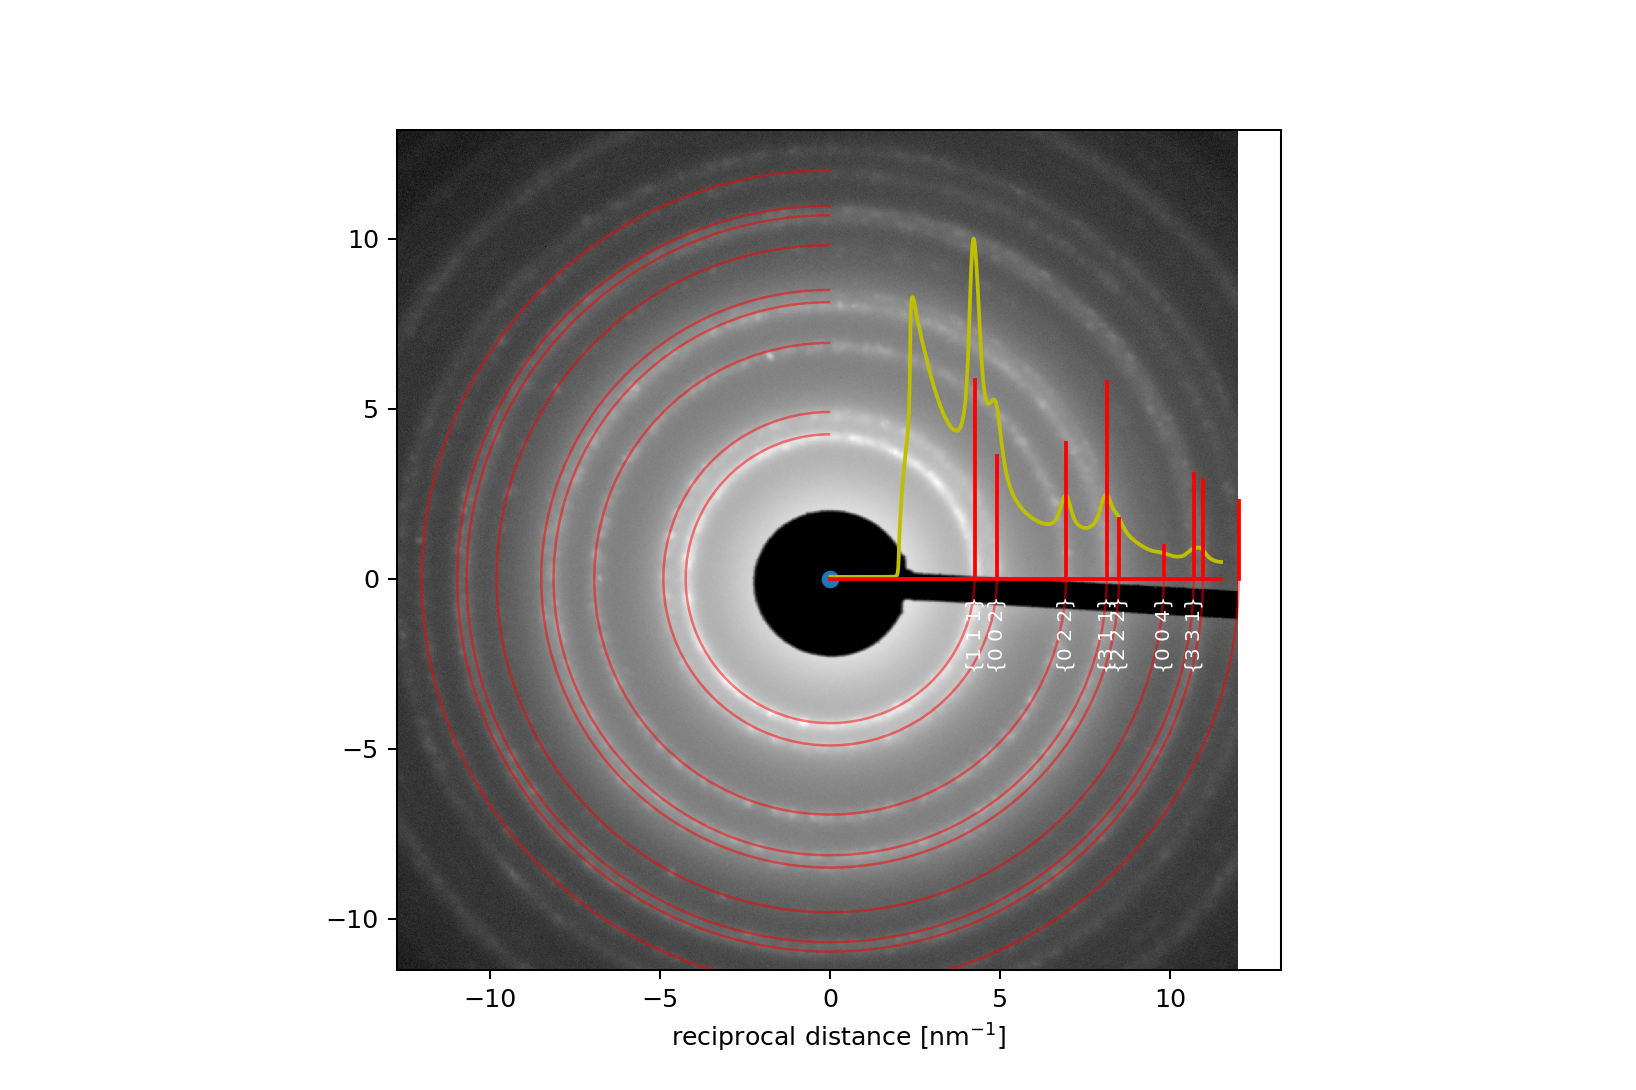

In [18]:
## Access the data of the loaded image
data = current_channel['Raw_Data'][()]
diff_pattern = np.reshape(data, [current_channel['spatial_size_x'][()], current_channel['spatial_size_y'][()]])
diff_pattern = diff_pattern-diff_pattern.min()

result_group = current_channel['Log_000']

center = result_group['center'][()]

from matplotlib import patches
fig = plt.figure(figsize=(9, 6)) 
ax = plt.gca()
extent= np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale

plt.imshow(np.log2(1+diff_pattern),cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')

profile = result_group['radial_average'][()]
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile/profile.max()*10, color='y');#
plt.plot((0,len(profile)*scale),(0,0),c='r')
reflections = {}
for key in result_group:
    if 'reflection' in key:
        keys = key.split('-')
        
        if keys[1] not in reflections:
            reflections[keys[1]]={}
        reflections[keys[1]][keys[2]] =  result_group[key][()]
        #print( reflections[keys[1]][keys[2]] )
scale = current_channel['spatial_scale_x'][()]*1.08
for key in reflections:
    distance = reflections[key]['recip_distances']
    if distance < len(profile)*scale:
        
        plt.plot([distance,distance], [0, reflections[key]['intensity']/1000],c='r')
        arc = patches.Arc((0,0), distance*2, distance*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);
for i in range(7):
    index = reflections[str(i)]['index'] # pretty index string
    plt.text(unique[i],-0.5, index, horizontalalignment='center',
          verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')


## Close File


In [ ]:
h5_file.close()